In [26]:
# Data analysis packages:
import pandas as pd
import numpy as np
#from datetime import datetime as dt

# Visualization packages:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.metrics import f1_score
from time import time
from operator import itemgetter
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import  cross_val_score
from __future__ import print_function

import os
import subprocess

from time import time
from operator import itemgetter
from scipy.stats import randint

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import  cross_val_score


filename = 'df_imputed_scaled_OHE_reduced.pkl'
df = pd.read_pickle(filename)

X = df[df.columns[:-1]]
y = pd.Series(df['heartdisease'])




In [27]:
def report(grid_scores, n_top=3):
    """Report top n_top parameters settings, default n_top=3.

    Args
    ----
    grid_scores -- output from grid or random search
    n_top -- how many to report, of top models

    Returns
    -------
    top_params -- [dict] top parameter settings found in
                  search
    """
    top_scores = sorted(grid_scores,
                        key=itemgetter(1),
                        reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print(("Mean validation score: "
               "{0:.3f} (std: {1:.3f})").format(
               score.mean_validation_score,
               np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

    return top_scores[0].parameters

In [28]:
def run_gridsearch(X, y, clf, param_grid, cv=5):
    """Run a grid search for best Decision Tree parameters.

    Args
    ----
    X -- features
    y -- targets (classes)
    cf -- scikit-learn Decision Tree
    param_grid -- [dict] parameter settings to test
    cv -- fold of cross-validation, default 5

    Returns
    -------
    top_params -- [dict] from report()
    """
    grid_search = GridSearchCV(clf,
                               param_grid=param_grid,
                               cv=cv)
    start = time()
    grid_search.fit(X, y)

    print(("\nGridSearchCV took {:.2f} "
           "seconds for {:d} candidate "
           "parameter settings.").format(time() - start,
                len(grid_search.grid_scores_)))

    top_params = report(grid_search.grid_scores_, 3)
    return  top_params

In [29]:
def run_randomsearch(X, y, clf, para_dist, cv=5,
                     n_iter_search=20):
    """Run a random search for best Decision Tree parameters.

    Args
    ----
    X -- features
    y -- targets (classes)
    cf -- scikit-learn Decision Tree
    param_dist -- [dict] list, distributions of parameters
                  to sample
    cv -- fold of cross-validation, default 5
    n_iter_search -- number of random parameter sets to try,
                     default 20.

    Returns
    -------
    top_params -- [dict] from report()
    """
    random_search = RandomizedSearchCV(clf,
                        param_distributions=param_dist,
                        n_iter=n_iter_search)

    start = time()
    random_search.fit(X, y)
    print(("\nRandomizedSearchCV took {:.2f} seconds "
           "for {:d} candidates parameter "
           "settings.").format((time() - start),
                               n_iter_search))

    top_params = report(random_search.grid_scores_, 3)
    return  top_params

In [30]:
def visualize_tree(tree, feature_names, fn="dt"):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn Decision Tree.
    feature_names -- list of feature names.
    fn -- [string], root of filename, default `dt`.
    """
    dotfile = fn + ".dot"
    pngfile = fn + ".png"

    with open(dotfile, 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", dotfile, "-o", pngfile]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, "
             "to produce visualization")

In [31]:
def get_code(tree, feature_names, target_names,
             spacer_base="    "):
    """Produce psuedo-code for decision tree.

    Args
    ----
    tree -- scikit-leant DescisionTree.
    feature_names -- list of feature names.
    target_names -- list of target (class) names.
    spacer_base -- used for spacing code (default: "    ").

    Notes
    -----
    based on http://stackoverflow.com/a/30104792.
    """
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth):
        spacer = spacer_base * depth
        if (threshold[node] != -2):
            print(spacer + "if ( " + features[node] + " <= " + \
                  str(threshold[node]) + " ) {")
            if left[node] != -1:
                    recurse(left, right, threshold, features,
                            left[node], depth+1)
            print(spacer + "}\n" + spacer +"else {")
            if right[node] != -1:
                    recurse(left, right, threshold, features,
                            right[node], depth+1)
            print(spacer + "}")
        else:
            target = value[node]
            for i, v in zip(np.nonzero(target)[1],
                            target[np.nonzero(target)]):
                target_name = target_names[i]
                target_count = int(v)
                print(spacer + "return " + str(target_name) + \
                      " ( " + str(target_count) + " examples )")

    recurse(left, right, threshold, features, 0, 0)


In [32]:
print("-- 10-fold cross-validation "
      "[using setup from previous post]")
dt_old = DecisionTreeClassifier(min_samples_split=20,
                                random_state=99)
dt_old.fit(X, y)
scores = cross_val_score(dt_old, X, y, cv=10)
print("mean: {:.3f} (std: {:.3f})".format(scores.mean(),
                                          scores.std()),
                                          end="\n\n" )

-- 10-fold cross-validation [using setup from previous post]
mean: 0.710 (std: 0.074)



In [34]:
print("-- Grid Parameter Search via 10-fold CV")
from sklearn.model_selection import KFold,StratifiedKFold 


kfold = StratifiedKFold(n_splits=10, random_state=1)
# set of parameters to test
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

dt = DecisionTreeClassifier()
ts_gs = run_gridsearch(X, y, dt, param_grid, cv=10)

-- Grid Parameter Search via 10-fold CV

GridSearchCV took 10.99 seconds for 288 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.770 (std: 0.081)
Parameters: {'max_depth': 2, 'criterion': 'gini', 'max_leaf_nodes': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.770 (std: 0.081)
Parameters: {'max_depth': 2, 'criterion': 'gini', 'max_leaf_nodes': 10, 'min_samples_leaf': 10, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.766 (std: 0.080)
Parameters: {'max_depth': 2, 'criterion': 'gini', 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}



In [35]:
print("\n-- Best Parameters:")
for k, v in ts_gs.items():
    print("parameter: {:<20s} setting: {}".format(k, v))


-- Best Parameters:
parameter: max_depth            setting: 2
parameter: criterion            setting: gini
parameter: max_leaf_nodes       setting: 10
parameter: min_samples_leaf     setting: 10
parameter: min_samples_split    setting: 2


In [10]:
# test the retuned best parameters
print("\n\n-- Testing best parameters [Grid]...")
dt_ts_gs = DecisionTreeClassifier(**ts_gs)
scores = cross_val_score(dt_ts_gs, X, y, cv=10)
print("mean: {:.3f} (std: {:.3f})".format(scores.mean(),
                                          scores.std()),
                                          end="\n\n" )



-- Testing best parameters [Grid]...
mean: 0.765 (std: 0.077)



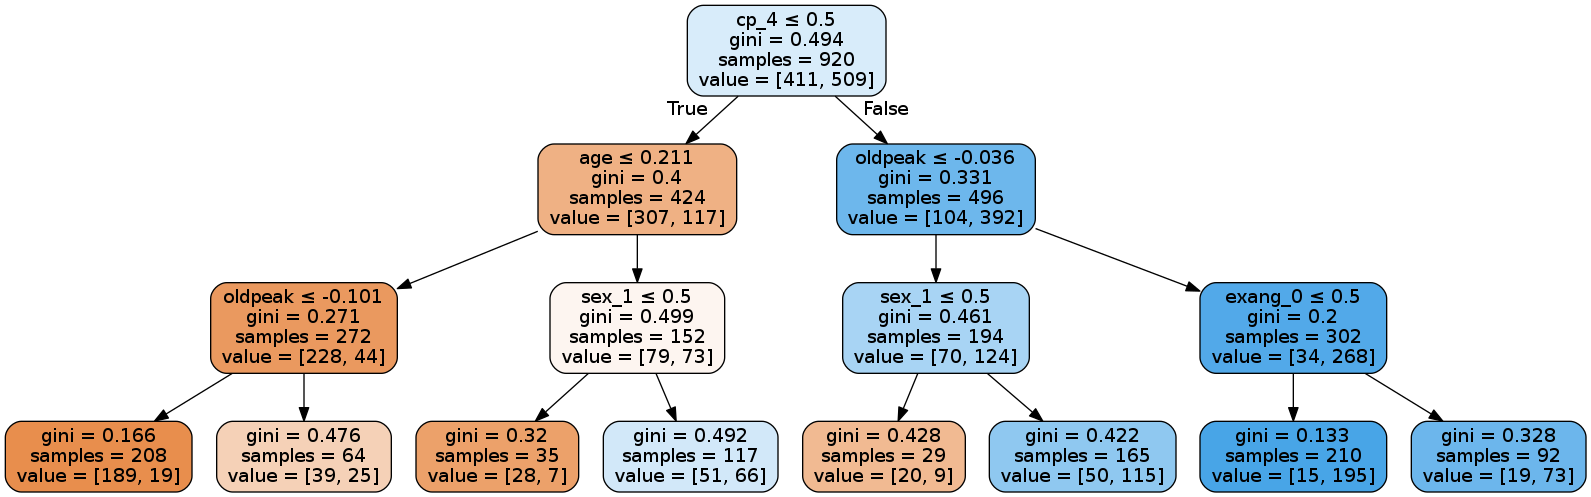

In [16]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()

_feature_names = []
target_names = ['No Disease', 'Disease']
for key, value in X.items():
    _feature_names.append(key)
dt_ts_gs.fit(X,y)
'''
dt_ts_gs.fit(X,y)
prediction4=dt_ts_gs.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_y))

pred_training = dt_ts_gs.predict(train_X)
print('Training Accuracy for Decision Tree is',metrics.accuracy_score(train_y, pred_training))
'''
export_graphviz(dt_ts_gs, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=_feature_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

plt.show(graph)

Image(graph.create_png())




In [17]:
get_code(dt_ts_gs, _feature_names, target_names)

if ( cp_4 <= 0.5 ) {
    if ( age <= 0.21117016673088074 ) {
        if ( oldpeak <= -0.10057684779167175 ) {
            return No Disease ( 189 examples )
            return Disease ( 19 examples )
        }
        else {
            return No Disease ( 39 examples )
            return Disease ( 25 examples )
        }
    }
    else {
        if ( sex_1 <= 0.5 ) {
            return No Disease ( 28 examples )
            return Disease ( 7 examples )
        }
        else {
            return No Disease ( 51 examples )
            return Disease ( 66 examples )
        }
    }
}
else {
    if ( oldpeak <= -0.036353837698698044 ) {
        if ( sex_1 <= 0.5 ) {
            return No Disease ( 20 examples )
            return Disease ( 9 examples )
        }
        else {
            return No Disease ( 50 examples )
            return Disease ( 115 examples )
        }
    }
    else {
        if ( exang_0 <= 0.5 ) {
            return No Disease ( 15 examples )
            return

In [36]:
print("-- Random Parameter Search via 10-fold CV")
from sklearn.model_selection import KFold,StratifiedKFold 


kfold = StratifiedKFold(n_splits=10, random_state=1)

# dict of parameter list/distributions to sample
param_dist = {"criterion": ["gini", "entropy"],
              "min_samples_split": randint(2, 20),
              "max_depth": randint(1, 20),
              "min_samples_leaf": randint(1, 20),
              "max_leaf_nodes": randint(2, 20)}

dt = DecisionTreeClassifier()
ts_rs = run_randomsearch(X, y, dt, param_dist, cv=kfold,
                         n_iter_search=288)

-- Random Parameter Search via 10-fold CV

RandomizedSearchCV took 2.94 seconds for 288 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.762 (std: 0.018)
Parameters: {'max_depth': 14, 'criterion': 'gini', 'max_leaf_nodes': 4, 'min_samples_leaf': 12, 'min_samples_split': 18}

Model with rank: 2
Mean validation score: 0.762 (std: 0.018)
Parameters: {'max_depth': 9, 'criterion': 'gini', 'max_leaf_nodes': 4, 'min_samples_leaf': 14, 'min_samples_split': 7}

Model with rank: 3
Mean validation score: 0.762 (std: 0.018)
Parameters: {'max_depth': 1, 'criterion': 'gini', 'max_leaf_nodes': 7, 'min_samples_leaf': 9, 'min_samples_split': 3}



In [37]:
print("\n-- Best Parameters:")
for k, v in ts_rs.items():
    print("parameters: {:<20s} setting: {}".format(k, v))


-- Best Parameters:
parameters: max_depth            setting: 14
parameters: criterion            setting: gini
parameters: max_leaf_nodes       setting: 4
parameters: min_samples_leaf     setting: 12
parameters: min_samples_split    setting: 18


In [38]:
# test the retuned best parameters
print("\n\n-- Testing best parameters [Random]...")
dt_ts_rs = DecisionTreeClassifier(**ts_rs)
scores = cross_val_score(dt_ts_rs, X, y, cv=10)
print("mean: {:.3f} (std: {:.3f})".format(scores.mean(),
                                          scores.std()),
                                          end="\n\n" )



-- Testing best parameters [Random]...
mean: 0.741 (std: 0.050)



In [39]:
print("\n-- get_code for best parameters [Random]:")
dt_ts_rs.fit(X,y)
get_code(dt_ts_rs, _feature_names, target_names)


-- get_code for best parameters [Random]:
if ( cp_4 <= 0.5 ) {
    if ( age <= 0.21117016673088074 ) {
        return No Disease ( 228 examples )
        return Disease ( 44 examples )
    }
    else {
        return No Disease ( 79 examples )
        return Disease ( 73 examples )
    }
}
else {
    if ( oldpeak <= -0.036353837698698044 ) {
        return No Disease ( 70 examples )
        return Disease ( 124 examples )
    }
    else {
        return No Disease ( 34 examples )
        return Disease ( 268 examples )
    }
}


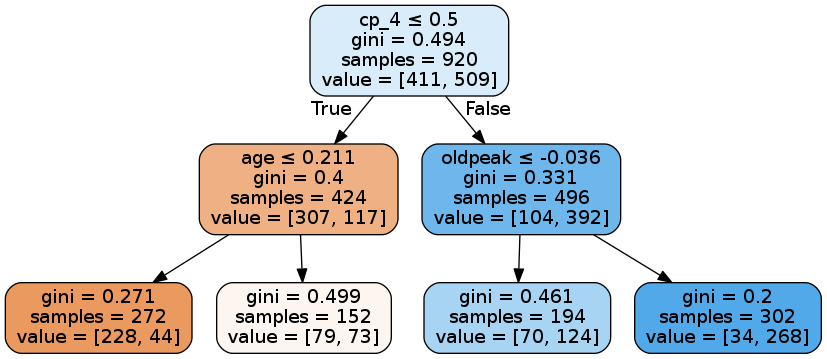

In [40]:
dot_data = StringIO()
export_graphviz(dt_ts_rs, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=_feature_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

plt.show(graph)

Image(graph.create_png())



In [41]:
train_X,test_X,train_y,test_y =train_test_split(X,y,test_size=0.2, random_state=45)
prediction4=dt_ts_rs.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_y))

pred_training = dt_ts_rs.predict(train_X)
print('Training Accuracy for Decision Tree is',metrics.accuracy_score(train_y, pred_training))

The accuracy of the Decision Tree is 0.8097826086956522
Training Accuracy for Decision Tree is 0.7472826086956522
